# Import relevant packages

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
import corner
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
from astropy.table import Table

# Simulate data
Simulate data with a smooth broken power law, with injected noise, following the model below:

$S_\nu(t) = S_{\rm \nu,peak} \left[ \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_1} + \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_2}\right]^{-1/s}$

Let us assume that all of our data is in a narrow enough frequency band that we do not have to consider the power law spectrum:

$ S_\nu(\nu) \propto \nu^\alpha$


In [91]:
# define smooth broken power law function
def smooth_broken_power_law(t, S_peak, t_peak, delta_1, delta_2, log_s):
    s = 10**log_s
    y = S_peak*((t/t_peak)**(-s*delta_1) + (t/t_peak)**(-s*delta_2))**(-1/s)
    return y

# define our input parameters
t = np.logspace(0, 3, 100)
S_peak = 100
t_peak = 150
delta_1 = 1.1
delta_2 = -0.8
log_s = 0.5

# generate smooth broken power law
true_relation = smooth_broken_power_law(t, S_peak, t_peak, delta_1, delta_2, log_s)

# inject gaussian noise 
ltnoise = np.random.normal(scale= 2, size=len(t))
gtnoise = np.random.normal(scale= 15, size=len(t))
# noise = np.random.uniform(-1, 1, len(t))

table = np.column_stack((t, true_relation))
data = Table(table, names=['time', 'flux'])
for i in range(0,len(data['time'])):
    if data['flux'][i] < 10:
        data['flux'][i] = data['flux'][i] + ltnoise[i]
    else:
        data['flux'][i] = data['flux'][i] + gtnoise[i]

# add some reasonable errors
err = 0.1*true_relation + np.random.normal(scale= 0.1, size=len(t))

data

time,flux
float64,float64
1.0,1.8017190401259018
1.0722672220103233,2.5382170380740345
1.1497569953977358,2.5015310806345377
1.2328467394420661,-1.9488839758591578
1.321941148466029,-0.2498377169905026
1.4174741629268053,-1.932568081505606
1.5199110829529336,0.6571538785280979
1.6297508346206442,4.493989380184686
1.7475284000076838,2.0080407289292728


# Make a plot of the lightcurve
follow the same modular procedure as in the <span style="text-decoration: underline;">Radio Light Curve Module</span> notebook

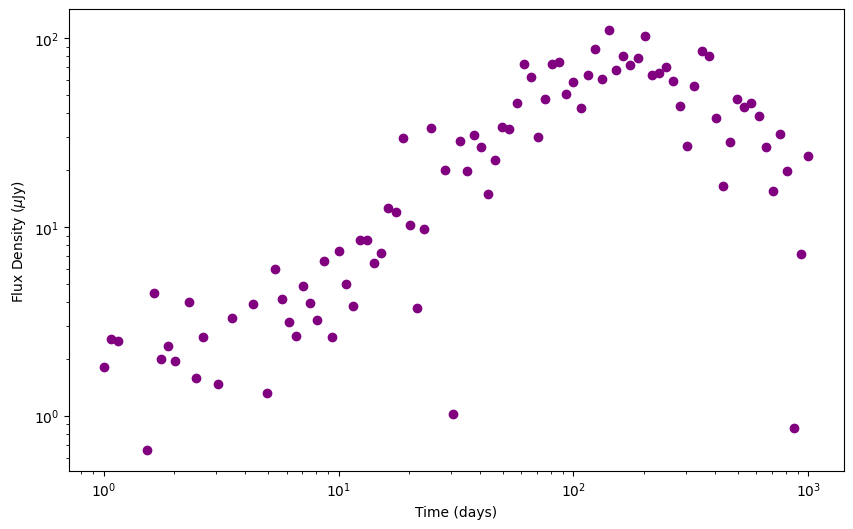

In [92]:
def plot_data(ax, data, scaled=False, **kwargs):
    for row in data:
        time = row['time']
        
        if scaled:
            flux = row['scaled_flux']
            #rms = row['scaled_rms']
        else:
            flux = row['flux']
            #rms = row['rms']

        ax.scatter(time, flux, color='purple', marker='o')
    return

def make_plot(data, scaled=False, model=None, params=None, tvals=np.arange(10,400), plot_models=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    plot_data(ax, data, scaled=scaled)

    # set axis scales to log
    ax.set_yscale('log')
    ax.set_xscale('log')

    #Label axes, set axis limits etc.
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
        ax.set_title('Scaled to 3 GHz')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')

make_plot(data)

# Determing and scaling data based on spectral index
If we had information across frequencies, we would perform this step. I will skip this step for now and just assume the 'data' is scaled to one frequency.

# Fitting the data 
We will now try to fit our simulated data to two models, one with a turnover, and another without. We will perform an MCMC  fit using the [`emcee`](http://dfm.io/emcee/current/) package to determine the lightcurve parameters of our data. 

One point of confusion for me is how to decide a good prior, probability, and likelihood. Of course, we know that $\delta_1>0$, and $\delta_2<0$, and I suppose we'll want to impose, for the turnover model, that $0<t_{peak}<1000$, as our simulated data only goes this far.

For now I will use the functions in the <span style="text-decoration: underline;">Radio Light Curve Module</span> notebook blindly until we can discuss this further

In [93]:
def lnprior(theta):
    F_peak, t_peak, delta_1, delta_2, log_s = theta

    if 0.0 < t_peak < 1000.0 and delta_1 > 0.0 and delta_2 < 0.0 and log_s < 3:
        return 0.0
    
    else:
        return -np.inf

In [95]:
def lnlike(theta, t, S):
    F_peak, t_peak, delta_1, delta_2, log_s = theta

    model = smooth_broken_power_law(t, F_peak, t_peak, delta_1, delta_2, log_s)

    return -0.5*(np.sum((S-model)**2))

In [ ]:
def lnprob(theta, t, S):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta, t, S)